<a href="https://colab.research.google.com/github/RayOfLight07/Deep-Learning/blob/main/DL_LAB_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning Lab_________________________________________________________________________Name: Deepasnhu Rathore     
B.Tech. 5th Sem.
#**Experiment:- 10**
# Introduction to Image Segmentation and Perform Image segmentation using UNet Model

Date:11\11\2025____________________________________________________________________________________SAP: 500124406

# **Aim**
To implement the U-Net architecture for semantic image segmentation using TensorFlow/Keras.

# **Objective**


*   To understand the difference between Image Classification and Image Segmentation (pixel-level classification).


*   To implement the Encoder-Decoder architecture with Skip Connections.
*   To evaluate the model using metrics like Accuracy and visual inspection of segmentation masks.

# **Theory**


*   Image Segmentation is the process of partitioning an image into multiple segments (sets of pixels). Unlike classification (which labels the whole image), segmentation labels every single pixel (e.g., "This pixel is a cat", "This pixel is grass").

*   U-Net Architecture: The U-Net is a convolutional neural network named after its U-shape. It consists of two paths:


     *   Contracting Path (Encoder): Acts like a standard CNN. It applies Convolution and Max Pooling to capture the "context" (what is in the image) but reduces the resolution.

     *   Expansive Path (Decoder): Uses Transposed Convolutions (Upsampling) to restore the image size for precise localization (where the object is).


*   Skip Connections: The unique feature of U-Net. It concatenates high-resolution feature maps from the Encoder directly to the Decoder. This preserves fine details (like the edges of the object) that are usually lost during pooling.

# Implementatation

Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


# **Load Standard Segmentation Dataset (Oxford Pets) **
We use tensorflow_datasets to load the data easily. The dataset contains images of pets and their "segmentation masks" (pixel-perfect labels).

In [ ]:
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    # Normalize image to [0, 1]
    input_image = input_image / 255.0

    # Masks are 1, 2, 3. We subtract 1 to make them 0, 1, 2 (Background, Border, Pet)
    input_mask -= 1

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image = input_image / 255.0
    input_mask -= 1
    return input_image, input_mask

# Download dataset (approx 700MB, takes ~1 min in Colab)
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

# Prepare Batches
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

print("Data Loaded Successfully.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.RHB82U_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.RHB82U_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Data Loaded Successfully.


# **Define U-Net Model Architecture**
 This defines the U-shape: Encoder (Down) -> Bottleneck -> Decoder (Up) with Skip Connections.

In [ ]:
def unet_model(output_channels):
    inputs = layers.Input(shape=[128, 128, 3])

    # --- Encoder (Downsampling) ---
    # Block 1
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # --- Bottleneck ---
    b = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, 3, activation='relu', padding='same')(b)

    # --- Decoder (Upsampling) ---
    # Block 3 (Up + Skip Connection from c2)
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)

    # Block 4 (Up + Skip Connection from c1)
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    # --- Output Layer ---
    # 3 Channels for 3 Classes: Pet, Background, Border
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(c4)

    return models.Model(inputs=inputs, outputs=outputs)

model = unet_model(output_channels=3)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,862,979 (7.11 MB)

 Trainable params: 1,862,979 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

# **Train the Model**
 Training for 5 epochs is enough to see the segmentation start working.

In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_dataset)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 92s 709ms/step - accuracy: 0.5833 - loss: 0.9393 - val_accuracy: 0.6296 - val_loss: 0.7991
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 500ms/step - accuracy: 0.6482 - loss: 0.7670 - val_accuracy: 0.6781 - val_loss: 0.7250
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 489ms/step - accuracy: 0.6824 - loss: 0.7067 - val_accuracy: 0.6838 - val_loss: 0.6978
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 487ms/step - accuracy: 0.6914 - loss: 0.6869 - val_accuracy: 0.6981 - val_loss: 0.6847
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 506ms/step - accuracy: 0.7078 - loss: 0.6573 - val_accuracy: 0.7161 - val_loss: 0.6582


# **Visualize Predictions**
This cell shows the Input Image, the Actual Mask (Ground Truth), and what your U-Net Predicted.

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step


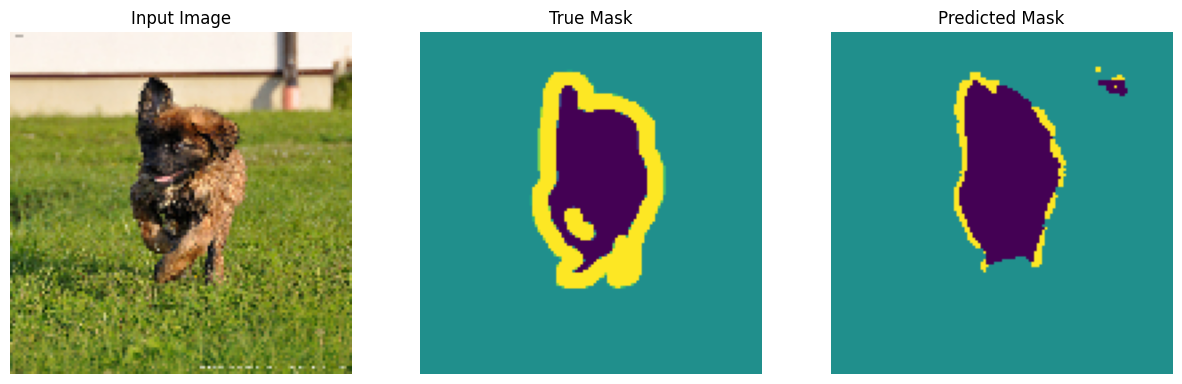

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


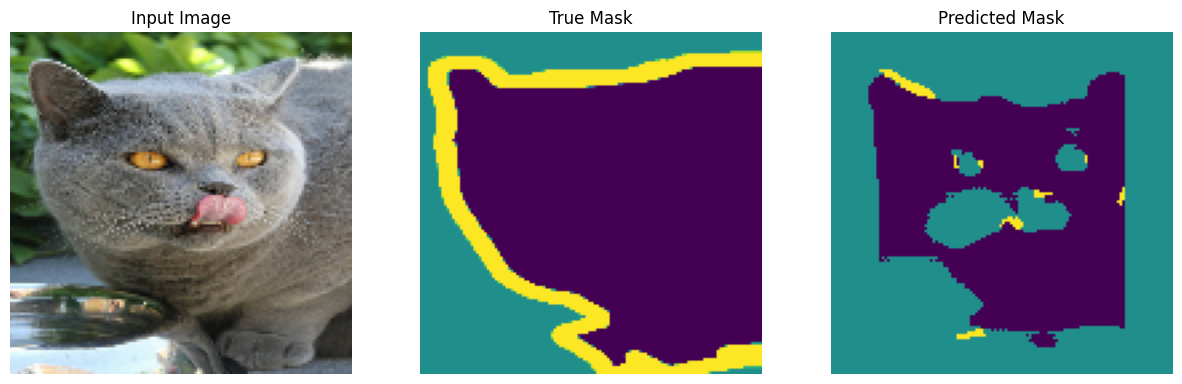

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


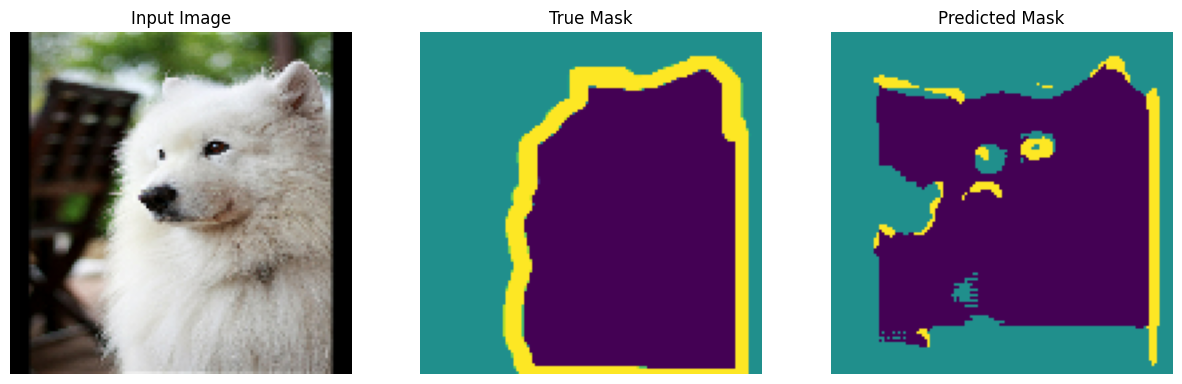

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=3):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_list = [image[0], mask[0], create_mask(pred_mask)]

            plt.figure(figsize=(15, 5))
            title = ['Input Image', 'True Mask', 'Predicted Mask']
            for i in range(len(display_list)):
                plt.subplot(1, len(display_list), i+1)
                plt.title(title[i])
                plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
                plt.axis('off')
            plt.show()

# Show results on test data
show_predictions(test_dataset, num=3)

# **Observations**

*   The U-Net model successfully learned to segment the pet from the background. The "Predicted Mask" closely resembles the "True Mask," identifying the shape of the animal.

*   The accuracy improved over epochs, confirming the skip connections helped the model retain spatial details.


# **Conclusion**


*    In this experiment, we implemented image segmentation using the U-Net architecture.

*   We observed that unlike simple classification networks, U-Net can output a pixel-by-pixel map, making it highly effective for tasks requiring precise object localization, such as medical imaging or autonomous driving.



